<a href="https://colab.research.google.com/github/Souvik2biswas/Solar-cycle-prediction/blob/main/SUN2CYCLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import seaborn as sns

In [173]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [252]:
data=pd.read_csv('/content/drive/MyDrive/Datasets/monthlySSA.csv')

In [253]:
data

,DATE,Area
0,1874-05-01,365.1
1,1874-06-01,415.2
2,1874-07-01,1033.5
3,1874-08-01,954.1
4,1874-09-01,335.3
...,...,...
1783,2022-12-01,1326.4
1784,2023-01-01,1846.2
1785,2023-02-01,1278.5
1786,2023-03-01,1013.2


In [249]:
data['DATE']=pd.to_datetime(data['DATE'])
data=data.set_index('DATE')

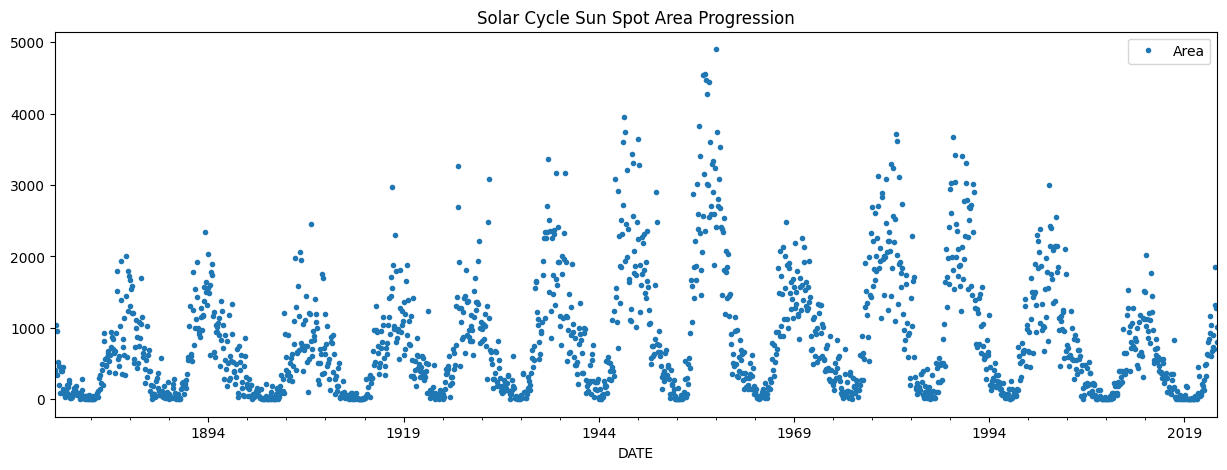

In [177]:
data.plot(style='.',
        figsize=(15, 5),
        title='Solar Cycle Sun Spot Area Progression')
plt.show()

In [250]:
data

,Area
DATE,
1874-05-01,365.1
1874-06-01,415.2
1874-07-01,1033.5
1874-08-01,954.1
1874-09-01,335.3
...,...
2022-12-01,1326.4
2023-01-01,1846.2
2023-02-01,1278.5


In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1788 entries, 1874-05-01 to 2023-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    1788 non-null   float64
dtypes: float64(1)
memory usage: 27.9 KB


<Axes: title={'center': 'Peaks'}, xlabel='DATE'>

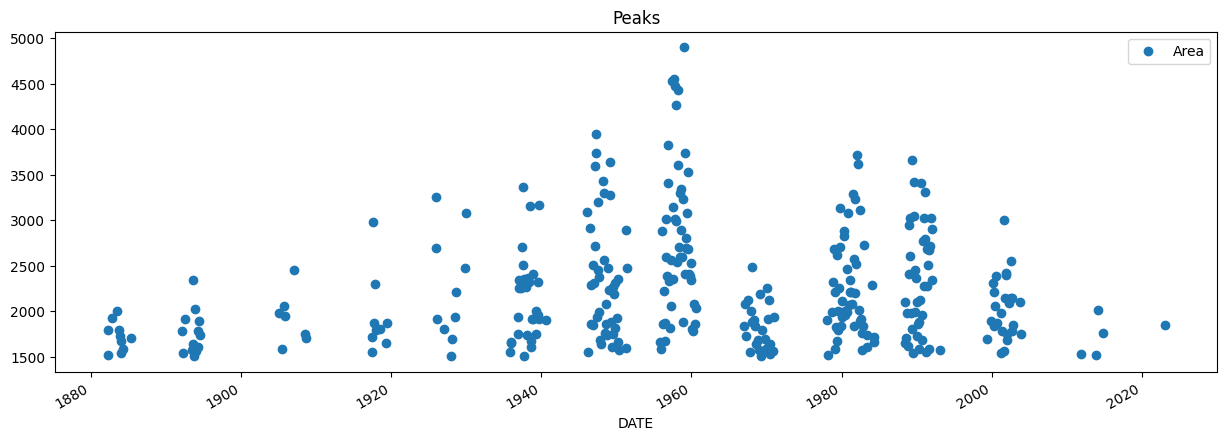

In [180]:
data.query('Area > 1500')\
    .plot(style='o',
          figsize=(15, 5),
          title='Peaks')

In [251]:
data.query('Area < 20')

,Area
DATE,
1876-04-01,15.8
1876-06-01,15.2
1877-07-01,4.2
1878-01-01,14.9
1878-02-01,18.1
...,...
2020-02-01,1.4
2020-03-01,1.4
2020-04-01,7.5


In [182]:
a = data.query('Area < 1000')
b = data.query('Area < 20')
c = data.query('Area > 1000')
plt.figure(figsize=(20,5), dpi=1000)
plt.scatter(x=a.index, y=a, marker='.', label='middle values')
plt.scatter(x=c.index, y=c, marker='.', label='upper values')
plt.scatter(x=b.index, y=b, marker='.', edgecolors='black', label='zero values')
plt.legend(['upper values', 'middle values','zero values'])
plt.show()

<Axes: title={'center': 'Peaks'}, xlabel='DATE'>

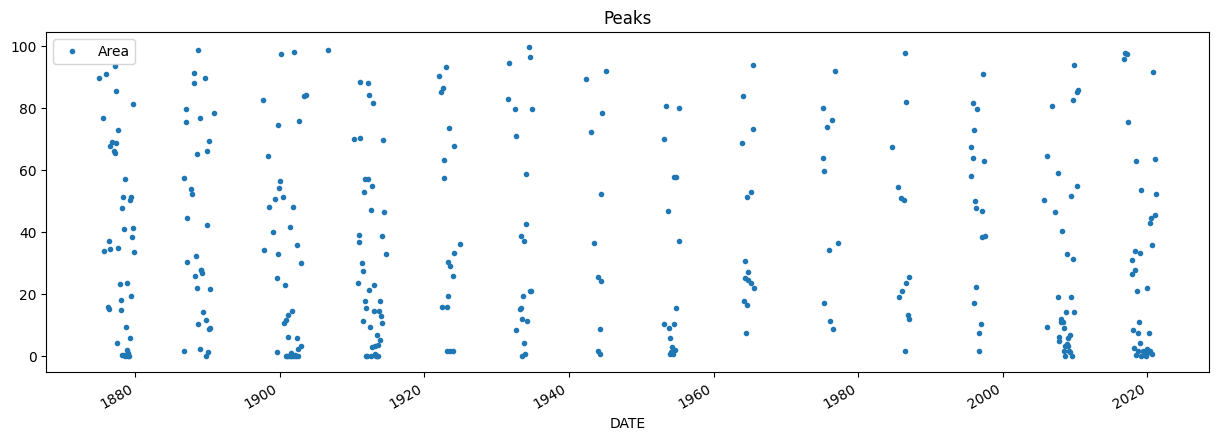

In [183]:
data.query('Area < 100') \
    .plot(style='.',
          figsize=(15, 5),
          title='Peaks')

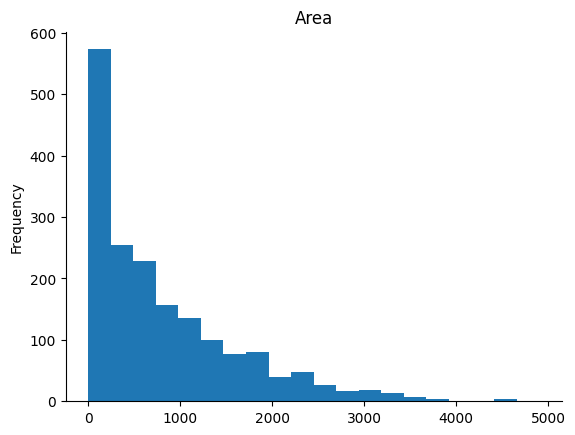

In [184]:
from matplotlib import pyplot as plt
data['Area'].plot(kind='hist', bins=20, title='Area')
plt.gca().spines[['top', 'right',]].set_visible(False)

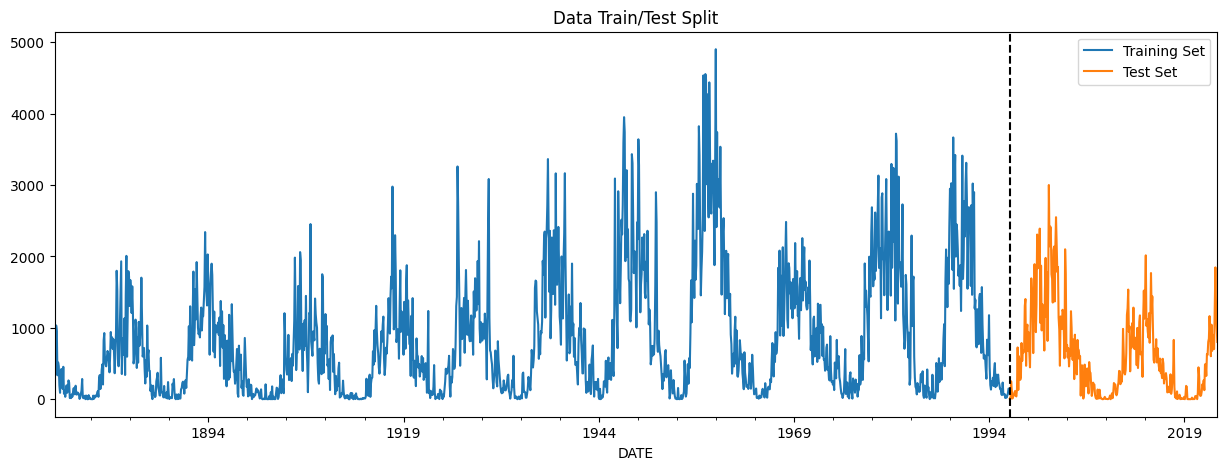

In [185]:
train_scaled = data.loc[data.index < '1996-09-01']
test_scaled = data.loc[data.index >= '1996-09-01']
fig, ax = plt.subplots(figsize=(15, 5))
train_scaled.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_scaled.plot(ax=ax, label='Test Set')
ax.axvline('1996-09-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [186]:
train_scaled

,Area
DATE,
1874-05-01,365.1
1874-06-01,415.2
1874-07-01,1033.5
1874-08-01,954.1
1874-09-01,335.3
...,...
1996-04-01,22.4
1996-05-01,47.9
1996-06-01,79.8


In [187]:
def prepare_data(timeseries_data, n_steps):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        end_ix = i + n_steps
        if end_ix > len(timeseries_data)-1:
            break
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [188]:
n_steps=96
X,y=prepare_data(train_scaled['Area'],n_steps)
val_X,val_y=prepare_data(test_scaled['Area'],n_steps)

In [189]:
X.shape

(1372, 96)

In [190]:
val_X.shape

(224, 96)

In [191]:
X

array([[ 365.1,  415.2, 1033.5, ...,  673.1,  928.9, 1799.1],
       [ 415.2, 1033.5,  954.1, ...,  928.9, 1799.1, 1519.6],
       [1033.5,  954.1,  335.3, ..., 1799.1, 1519.6,  557.8],
       ...,
       [1647.3, 2097.7, 1707.1, ...,   50.1,   22.4,   47.9],
       [2097.7, 1707.1, 1289.9, ...,   22.4,   47.9,   79.8],
       [1707.1, 1289.9, 1982.6, ...,   47.9,   79.8,  148.6]])

In [192]:
param_grid = {
    'bootstrap': [True, False],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 3, 4, 5],
    'warm_start': [True, False]
}


In [193]:
rfr_model = RandomForestRegressor(criterion='squared_error')

In [194]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=rfr_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 3, 4, 5],
                         'n_estimators': [50, 100, 200, 300],
                         'warm_start': [True, False]},
             scoring='neg_mean_squared_error')

In [195]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


In [196]:
predictions = best_model.predict(val_X).reshape(-1,1)

In [197]:
predictions

array([[ 798.744],
       [ 752.938],
       [ 530.196],
       [ 607.714],
       [ 340.656],
       [ 533.35 ],
       [ 511.056],
       [ 339.17 ],
       [ 335.862],
       [ 523.898],
       [ 615.75 ],
       [ 537.078],
       [ 569.752],
       [ 568.946],
       [ 279.24 ],
       [ 402.772],
       [ 451.822],
       [ 245.692],
       [ 155.428],
       [ 138.016],
       [ 385.972],
       [ 198.15 ],
       [ 202.372],
       [ 224.596],
       [ 353.028],
       [ 179.104],
       [  87.296],
       [ 492.954],
       [ 350.272],
       [ 292.848],
       [ 151.124],
       [ 129.102],
       [ 128.324],
       [ 167.942],
       [ 146.184],
       [ 181.426],
       [  98.212],
       [  76.014],
       [  57.72 ],
       [  48.806],
       [  95.806],
       [  59.6  ],
       [  49.056],
       [ 155.998],
       [ 107.036],
       [  68.048],
       [  52.602],
       [  58.742],
       [  34.7  ],
       [  44.402],
       [  58.044],
       [  42.656],
       [  43

In [198]:
rmse = np.sqrt(MSE(predictions,val_y))

In [199]:
rmse

228.03089303284577

In [200]:
from sklearn.metrics import r2_score as R2
R2_score=R2(predictions,val_y)
R2_score

0.6577557400520408

In [201]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(predictions, val_y)
MAPE

0.5323064311696385

In [202]:
train_predict = best_model.predict(X).reshape(-1,1)
test_predict = best_model.predict(val_X).reshape(-1,1)

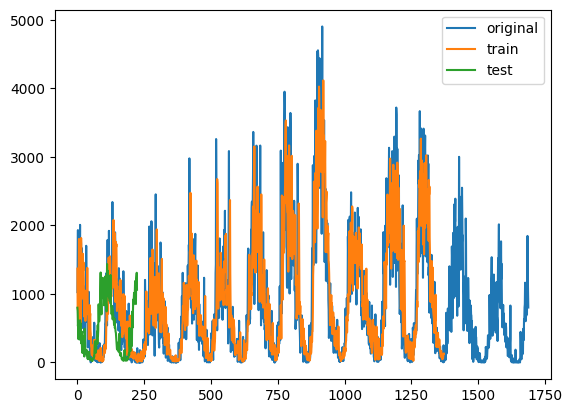

In [203]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.plot(np.array(data[100:]),label='original')
plt.plot(train_predict,label='train')
plt.plot(test_predict,label='test')
plt.legend()
plt.show()

In [204]:
test = np.vstack((train_predict,test_predict))

In [205]:
data1=data[100:]

In [206]:
date=pd.Series(pd.period_range("1/9/1882", freq="M", periods=len(data1)))

In [207]:
test=test.flatten()

In [208]:
data_scaled1=data[100:]

In [209]:
DF = pd.DataFrame()
DF['original'] = data_scaled1
DF = DF.set_index(date)

In [210]:
DF1=pd.DataFrame()
DF1['predicted']=test
DF1 = DF1.set_index(date[:-92])

In [211]:
new = pd.concat([DF, DF1], ignore_index=False, axis=1)

In [212]:
new.head()

,original,predicted
1882-01,1026.9,1368.782
1882-02,1393.8,791.732
1882-03,1931.1,773.926
1882-04,352.9,620.054
1882-05,849.8,963.166


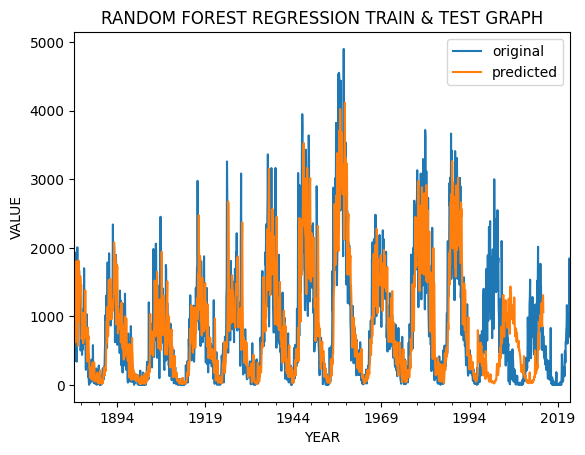

In [213]:
new.plot()
plt.title('RANDOM FOREST REGRESSION TRAIN & TEST GRAPH',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_train_test.png')

In [214]:
len(test_predict),len(val_y)

(224, 224)

In [215]:
len(data)

1788

In [216]:
data_n=data[:1759]

In [217]:
data_n.tail

<bound method NDFrame.tail of               Area
DATE              
1874-05-01   365.1
1874-06-01   415.2
1874-07-01  1033.5
1874-08-01   954.1
1874-09-01   335.3
...            ...
2020-07-01    44.5
2020-08-01    36.1
2020-09-01     0.9
2020-10-01    91.7
2020-11-01   446.4

[1759 rows x 1 columns]>

In [218]:
import numpy as np

t_df = np.array(data_n).reshape(-1,1)

In [219]:
len(t_df)

1759

In [220]:
fut_inp = t_df[1663:]

In [221]:
fut_inp = fut_inp.reshape(1,-1)

In [222]:
tmp_inp = list(fut_inp)

In [223]:
fut_inp.shape

(1, 96)

In [224]:
tmp_inp = tmp_inp[0].tolist()

In [225]:
predictions

array([[ 798.744],
       [ 752.938],
       [ 530.196],
       [ 607.714],
       [ 340.656],
       [ 533.35 ],
       [ 511.056],
       [ 339.17 ],
       [ 335.862],
       [ 523.898],
       [ 615.75 ],
       [ 537.078],
       [ 569.752],
       [ 568.946],
       [ 279.24 ],
       [ 402.772],
       [ 451.822],
       [ 245.692],
       [ 155.428],
       [ 138.016],
       [ 385.972],
       [ 198.15 ],
       [ 202.372],
       [ 224.596],
       [ 353.028],
       [ 179.104],
       [  87.296],
       [ 492.954],
       [ 350.272],
       [ 292.848],
       [ 151.124],
       [ 129.102],
       [ 128.324],
       [ 167.942],
       [ 146.184],
       [ 181.426],
       [  98.212],
       [  76.014],
       [  57.72 ],
       [  48.806],
       [  95.806],
       [  59.6  ],
       [  49.056],
       [ 155.998],
       [ 107.036],
       [  68.048],
       [  52.602],
       [  58.742],
       [  34.7  ],
       [  44.402],
       [  58.044],
       [  42.656],
       [  43

In [226]:
lst_output=[]
n_steps=96
i=0
while(i<133):

    if(len(tmp_inp)>96):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape(( 1,n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[[504.5700000000002], [511.944], [689.6400000000003], [805.834], [931.4480000000002], [957.6420000000002], [874.7020000000001], [886.4500000000003], [1002.5520000000002], [978.5360000000004], [1072.728], [1100.268], [1047.424], [1151.0280000000002], [1227.096], [1252.698], [1469.7179999999998], [1559.7139999999997], [1450.9959999999999], [1488.2220000000004], [1483.9139999999998], [1350.368], [1343.0279999999998], [1452.8779999999997], [1573.106], [1558.66], [1636.3959999999997], [1616.2460000000003], [1486.4339999999993], [1593.3439999999996], [1700.9279999999999], [1753.816], [1734.2519999999995], [1746.0339999999994], [1796.6219999999998], [1806.844], [1753.3180000000002], [1788.0260000000003], [1823.838000000001], [1800.6259999999997], [1761.8739999999996], [1541.8300000000004], [1727.5720000000008], [1709.8700000000003], [1535.1580000000004], [1742.802], [1571.7199999999998], [1294.3520000000003], [1284.1480000000001], [1247.428], [1370.024], [1221.582], [1139.2279999999998], [109

In [227]:
lst_output

[[504.5700000000002],
 [511.944],
 [689.6400000000003],
 [805.834],
 [931.4480000000002],
 [957.6420000000002],
 [874.7020000000001],
 [886.4500000000003],
 [1002.5520000000002],
 [978.5360000000004],
 [1072.728],
 [1100.268],
 [1047.424],
 [1151.0280000000002],
 [1227.096],
 [1252.698],
 [1469.7179999999998],
 [1559.7139999999997],
 [1450.9959999999999],
 [1488.2220000000004],
 [1483.9139999999998],
 [1350.368],
 [1343.0279999999998],
 [1452.8779999999997],
 [1573.106],
 [1558.66],
 [1636.3959999999997],
 [1616.2460000000003],
 [1486.4339999999993],
 [1593.3439999999996],
 [1700.9279999999999],
 [1753.816],
 [1734.2519999999995],
 [1746.0339999999994],
 [1796.6219999999998],
 [1806.844],
 [1753.3180000000002],
 [1788.0260000000003],
 [1823.838000000001],
 [1800.6259999999997],
 [1761.8739999999996],
 [1541.8300000000004],
 [1727.5720000000008],
 [1709.8700000000003],
 [1535.1580000000004],
 [1742.802],
 [1571.7199999999998],
 [1294.3520000000003],
 [1284.1480000000001],
 [1247.428],
 

In [228]:
n_steps=96

X1,y1=prepare_data(t_df,n_steps)

In [229]:
X1.shape

(1663, 96, 1)

In [230]:
arr = np.array([X1])

X1 = arr.reshape(1663, 96)

In [231]:
train_p=best_model.predict(X1).reshape(-1,1)

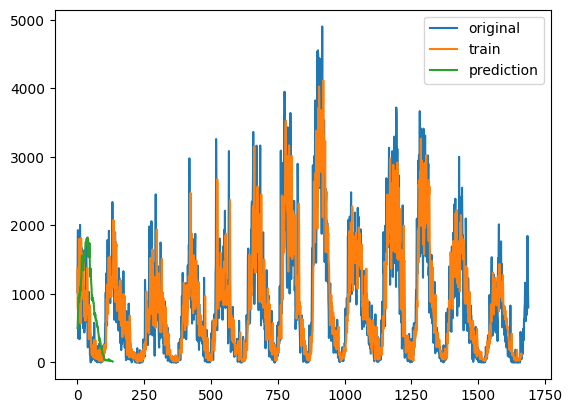

In [232]:
plt.plot(np.array(data[100:]),label='original')
plt.plot(train_p,label='train')
plt.plot(lst_output,label='prediction')
plt.legend()
plt.show()

In [233]:
type(train_p)

numpy.ndarray

In [234]:

test = np.vstack((train_p,lst_output))

In [235]:
test=test.flatten()

In [236]:
data_n = np.array(data_n).reshape(-1,1)

In [237]:
data_scaled2 = data_n[100:]

In [238]:
date=pd.Series(pd.period_range("1/9/1882", freq="M", periods=len(data_scaled1)+133))

In [239]:
DF = pd.DataFrame()
DF['original'] = data_scaled1
DF = DF.set_index(date[:-133])

In [240]:
DF1=pd.DataFrame()
DF1['predicted']=test
DF1 = DF1.set_index(date[:-25])

In [241]:
new = pd.concat([DF, DF1], ignore_index=False, axis=1)

In [242]:
new

,original,predicted
1882-01,1026.9,1368.782
1882-02,1393.8,791.732
1882-03,1931.1,773.926
1882-04,352.9,620.054
1882-05,849.8,963.166
...,...,...
2031-04,NaN,20.204
2031-05,NaN,18.478
2031-06,NaN,18.538
2031-07,NaN,17.656


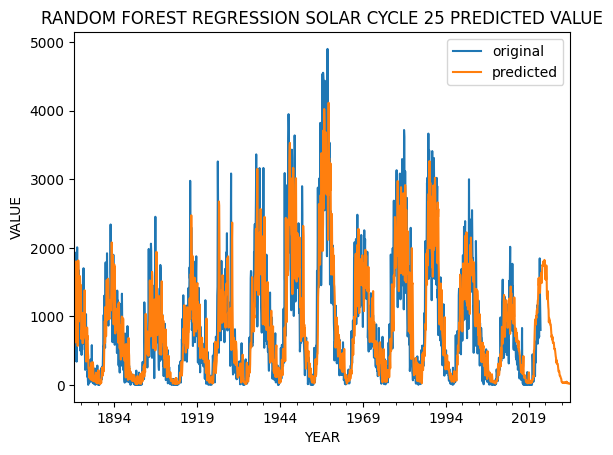

In [243]:
new.plot()
plt.title('RANDOM FOREST REGRESSION SOLAR CYCLE 25 PREDICTED VALUE',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_predict.png')

In [244]:
print("Largest element is:", max(lst_output))

Largest element is: [1823.838000000001]


In [245]:
i=max(lst_output)
time=int(np.where(np.array(lst_output) == i)[0])
time

38

In [246]:
new_date = np.datetime64('2020-11') + np.timedelta64(time, 'M')
print('Peak month is : '+str(new_date))


Peak month is : 2024-01
